In [75]:
import torch
import torchaudio
import os
import glob
import IPython.display as ipd
import pandas as pd

LABELS_DIR = 'labels'
WAV_DIR = 'audio/parts'

In [54]:
wavs = sorted(glob.glob(os.path.join(WAV_DIR, '*.wav')))

In [ ]:
def read_audio_filtered(wav, ...):
    return waveform, sample_rate

In [136]:
csv_dtype = {
    'Start [s]': float,
    'End [s]': float,
    'Speaker': str
}

filtered_wavs = []
loaded_wavs = []
label_dfs = []

fade_samples = 1000
fade_in = torch.sigmoid(torch.linspace(-5, 5, fade_samples))
fade_out = torch.sigmoid(torch.linspace(5, -5, fade_samples))

for wav in wavs:
    # Get the matching label file
    label_file = os.path.join(LABELS_DIR, f'{os.path.basename(wav).split('.')[0]}_unwanted.csv')
    label_df = pd.read_csv(label_file, dtype=csv_dtype)

    waveform, sample_rate = torchaudio.load(wav)
    
    label_df['Start'] = (label_df['Start [s]'] * sample_rate).astype(int).clip(0, waveform.shape[1])
    label_df['End'] = (label_df['End [s]'] * sample_rate).astype(int).clip(0, waveform.shape[1])
    label_dfs.append(label_df)
    
    loaded_wavs.append((waveform.clone(), sample_rate))
    
    for start_idx, end_index in zip(label_df['Start'], label_df['End']):
        fade_in_end_idx = max(0, min(start_idx + fade_samples, waveform.shape[1]))
        fade_in_samples = fade_in_end_idx - start_idx
        fade_out_start_idx = max(0, min(end_index - fade_samples, waveform.shape[1]))
        fade_out_samples = end_index - fade_out_start_idx
        waveform[:, start_idx:fade_in_end_idx] *= fade_in[fade_in.shape[0] - fade_in_samples:]
        waveform[:, fade_in_end_idx:fade_out_start_idx] = 0
        waveform[:, fade_out_start_idx:end_index] *= fade_out[:-fade_out_samples+1]

    filtered_wavs.append((waveform, sample_rate))
    

Show the dataframe with unwanted speakers. 

In [137]:
idx = 32
label_dfs[idx]

,Start [s],End [s],Speaker,Start,End
0,3.658744,4.439728,SPEAKER_01,58539,71035
1,6.544992,10.466893,SPEAKER_01,104719,167470
2,10.993209,14.151104,SPEAKER_01,175891,226417


Play the original audio.

In [138]:
waveform, sample_rate = loaded_wavs[idx]
ipd.display(ipd.Audio(waveform, rate=sample_rate))

Play the filtered audio.

In [140]:
waveform, sample_rate = filtered_wavs[idx]
ipd.display(ipd.Audio(waveform, rate=sample_rate))

Visualize the `fade_in` and `fade_out` curves applied to mute unwanted speakers.

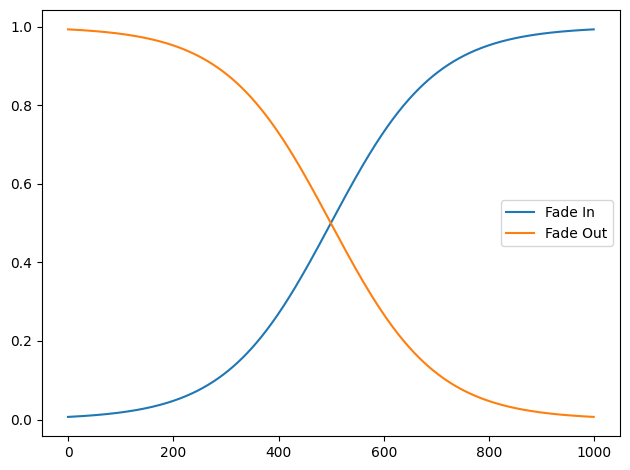

In [139]:
import matplotlib.pyplot as plt

plt.plot(fade_in, label='Fade In')
plt.plot(fade_out, label='Fade Out')
plt.legend()
plt.tight_layout()